In [122]:
%pip install sklearn
%pip install pillow
%pip install torchvision
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Dataset

In [123]:
import PIL as Image
import torch
import torchvision.transforms as transforms
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from skimage import io
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#Preparing the dataset
annotations = pd.read_csv("Datasets/annotations.csv")
HP = annotations.iloc[:,1] == "HP"
SSA = annotations.iloc[:,1] == "SSA"
annotations["HP"] = HP
annotations["SSA"] = SSA
t_annotations = annotations[annotations["Partition"]=="train"]

train_annotations, val_annotations = train_test_split(t_annotations, train_size=0.8, stratify=t_annotations["HP"])

# Just to confirm if the distribution is the same 
print(len(train_annotations[HP] == True), len(train_annotations))
print(len(val_annotations[HP] == True), len(val_annotations))
test_annotations = annotations[annotations["Partition"]=="test"]
root_dir = "Datasets/images/"

class Plyops(Dataset):
  def __init__(self, annotations, root_dir, transform = None) -> None:
    self.annotations = annotations
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)

    if self.transform:
      image = self.transform(image)
    
    y_label = torch.tensor([int(self.annotations.iloc[index, 4]),int(self.annotations.iloc[index, 5])])
    return (image, y_label)
  
  
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(size=(227, 227)), transforms.ToTensor()])

train_dataset = Plyops(train_annotations, root_dir, transform)
val_dataset = Plyops(val_annotations, root_dir, transform)
test_dataset = Plyops(test_annotations, root_dir, transform)

batch_size = 32

train_dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size), 'val': DataLoader(val_dataset, batch_size=batch_size)}
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

dataset_sizes = {'train': len(train_dataloaders['train']), 'val': len(train_dataloaders['val']), 'test': len(test_dataloader)}

1236 1740
309 435


/var/folders/hl/86tbqlkd413g631jyj246ld00000gn/T/ipykernel_78100/738772028.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(train_annotations[HP] == True), len(train_annotations))
/var/folders/hl/86tbqlkd413g631jyj246ld00000gn/T/ipykernel_78100/738772028.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(val_annotations[HP] == True), len(val_annotations))


Models

In [151]:
import torch.nn as nn
from einops import rearrange

class AlexNet(nn.Module):
  def __init__(self, num_classes):
    super(AlexNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 96, kernel_size=(11,11), stride=4)
    self.act1 = nn.ReLU()
    self.max_pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=2)
    self.norm1 = nn.BatchNorm2d(num_features=96)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=(5,5), padding=2)
    self.act2 = nn.ReLU()
    self.max_pool2 = nn.MaxPool2d(kernel_size=(3,3), stride=2)
    self.norm2 = nn.BatchNorm2d(num_features=256)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=(3,3), stride=1, padding=1)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=(3,3), stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=(3,3) ,stride=1, padding=1)
    self.act3 = nn.ReLU()
    self.max_pool3 = nn.MaxPool2d(kernel_size=(3,3), stride= 2)
    self.fc1 = nn.Linear(9216, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, num_classes)
    self.softmax = nn.Softmax(dim = 1)
  
  def forward(self, x):
    x = self.norm1(self.max_pool1(self.act1(self.conv1(x))))
    x = self.norm2(self.max_pool2(self.act2(self.conv2(x))))
    x= self.max_pool3(self.act3(self.conv5(self.conv4(self.conv3(x)))))
    x = rearrange(x, 'b h w c -> b (h w c)')
    x = self.fc3(self.fc2(self.fc1(x)))
    x = self.softmax(x)
    return x 

**Training and Testing**

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def visualize(*args, labels):
  n = len(args[0])
  x = np.arange(0,n, 1)
  assert len(args) == len(labels), "Each list must have a corresponding label"
  #Defining the functions used for plotting
  for i in range(len(args)):
    assert len(args[i]) == n, "incorrect number of values"
    plt.plot(x, args[i], label = labels[i])
  plt.xlim(0,n-1)
  plt.xticks(range(0,n-1))
  plt.ylim(0,1)
  plt.title("Model Evaluation")
  plt.xlabel("Epochs")
  plt.ylabel("Metrics")
  plt.legend()
  plt.show()

def visualize_training(*args):
  labels = ["Precision", "Recall", "F1", "Specificity"]
  visualize(*args, labels= labels)

def visualize_testing(c_matrix):
  pass

In [150]:
from numpy import mean
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score


def training_loop(dataloader, model, epochs, loss_function, optimizer, scheduler = None):
  epoch_losses = []
  epoch_precisions = []
  epoch_recalls = []
  epoch_f1_scores = []
  epoch_specificities = []
  for epoch in range(epochs):
    print("Epoch: " + str(epoch))
    batch_tn = []
    batch_fp = []
    batch_tp = []
    batch_fn = []
    batch_losses = []
    for x in ['train', 'val']:
      if x == 'train':
        model.train()
      else:
        model.eval()
      for (data, label) in dataloader[x]:
        data = data.to(torch.float32)
        label = label.to(torch.float32)
        data, label = data.to(device), label.to(device)
        output = model(data)
        output.to(device)
        loss = loss_function(output, label)
        optimizer.zero_grad()
        with torch.no_grad():
          predictions = torch.argmax(output, 1)
          label = torch.argmax(label, 1)
          tn, fp, fn, tp = confusion_matrix(label, predictions, labels=[0,1]).ravel()

        if x == 'train':
          loss.backward()
          optimizer.step()
        else:
          batch_losses.append(loss.item())
          batch_tn.append(tn)
          batch_fp.append(fp)
          batch_tp.append(tp)
          batch_fn.append(fn)

    epoch_loss = mean(batch_losses)
    epoch_losses.append(epoch_loss)
    epoch_tn, epoch_fp, epoch_tp, epoch_fn = sum(batch_tn), sum(batch_fp), sum(batch_tp), sum(batch_fn)
    
    if scheduler:
        scheduler.step(epoch_loss)

    epoch_precision = epoch_tp/(epoch_tp + epoch_fp) if epoch_tp + epoch_fp != 0 else 0
    epoch_precisions.append(epoch_precision)
    epoch_recall = epoch_tp/(epoch_tp + epoch_fn) if epoch_tp + epoch_fp != 0 else 1
    epoch_recalls.append(epoch_recall)
    epoch_f1 = (2*epoch_recall*epoch_precision)/(epoch_recall + epoch_precision) if epoch_recall + epoch_precision != 0 else 0
    epoch_f1_scores.append(epoch_f1)
    epoch_specificity = epoch_tn/(epoch_tn + epoch_fp) if epoch_tn + epoch_fp != 0 else 1
    epoch_specificities.append(epoch_specificity)
          
    print("Precision: " + str(epoch_precision) 
          + " F1: " + str(epoch_f1))
    print("Recall: " + str(epoch_recall) + " Specificity: " + str(epoch_specificity))
    print("Loss: " + str(epoch_loss))

  return [epoch_precisions, epoch_recalls, epoch_f1_scores, epoch_specificities]


In [149]:
import torch.optim as optim
#large learning rate since not much time to train
lr = 5e-4
model = AlexNet(2)

loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
#Small number of epochs since we dont have the computational resources
epochs = 25

args = training_loop(train_dataloaders, model, epochs, loss_function, optimizer, scheduler)

visualize_training(*args)


Epoch: 0


UnboundLocalError: local variable 'epoch_loss' referenced before assignment

Lets test the model

In [136]:
import itertools
from tabulate import tabulate

def test(test_dataloader, model):
  model.eval()
  #Assumes that batch_size = len(test_dataloader)
  for data, label in test_dataloader:
    data = data.to(torch.float32)
    label = label.to(torch.float32)
    data, label = data.to(device), label.to(device)
    output = model(data)
    with torch.no_grad():
      predictions = torch.argmax(output, 1)
      label = torch.argmax(label, 1)
      return confusion_matrix(label, predictions, labels=[0,1]), classification_report(label, predictions, output_dict=True)

def visualize_testing(cm):
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, [0,1], rotation=45)
  plt.yticks(tick_marks, [0,1])
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  
  

/Users/madhavgopakumar/.pyenv/versions/3.10.7/envs/cv-project-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/madhavgopakumar/.pyenv/versions/3.10.7/envs/cv-project-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/madhavgopakumar/.pyenv/versions/3.10.7/envs/cv-project-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

[[617   0]
 [360   0]]
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label   │   Precision │   Recall │   F1-score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ HP      │    0.631525 │        1 │   0.774153 │       617 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ SSA     │    0        │        0 │   0        │       360 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛


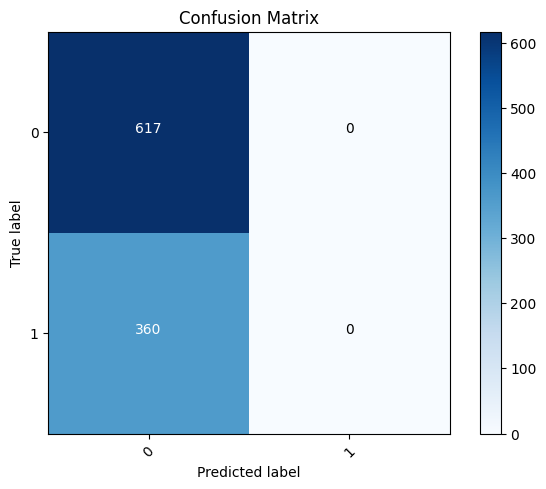

In [129]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))

**Balancing the Dataset**

In [134]:
from imblearn.over_sampling import RandomOverSampler
#We are going to try Random oversampling with image augmentation first
train_transforms2 = transforms.Compose([transforms.ToPILImage(), 
                                       transforms.Resize(size=(227, 227)), 
                                       transforms.RandomHorizontalFlip(), 
                                       transforms.RandomAdjustSharpness(sharpness_factor=0.8),
                                       transforms.RandomGrayscale(),transforms.ToTensor()])

#We are going to apply random transformation to each of the training examples, and see their effect on the model in addition
#Note that t_annotations is only the training data not the testing
ros = RandomOverSampler(random_state=0)
t_annotations_data, t_annotations_target = ros.fit_resample(t_annotations.drop(["HP"], axis=1), t_annotations['HP'])
print(len(t_annotations_data["SSA"] == True), len(t_annotations_data["SSA"] == False))
t_annotations_data["HP"] = t_annotations_target
train_annotations_ros, val_annotations_ros = train_test_split(t_annotations_data, train_size=0.8, stratify=t_annotations_data["HP"])

#Below is the training datasets with transformations applied
train_dataset_ros = Plyops(train_annotations_ros, root_dir, train_transforms2)
val_dataset_ros = Plyops(val_annotations_ros, root_dir, train_transforms2)

batch_size = 32

train_dataloaders_ros = {'train': DataLoader(train_dataset_ros, batch_size=batch_size), 
                                                    'val': DataLoader(val_dataset_ros, batch_size=batch_size)}

3090 3090


Epoch: 0
Precision: 0.5984555984555985 F1: 0.545774647887324
Recall: 0.5016181229773463 Specificity: 0.6634304207119741
Loss: 0.6774927943944931
Epoch: 1
Precision: 0.6431372549019608 F1: 0.5815602836879433
Recall: 0.5307443365695793 Specificity: 0.7055016181229773
Loss: 0.6525822311639786


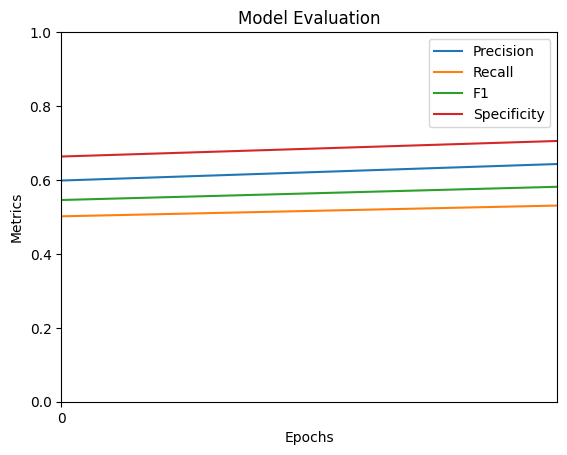

In [104]:
lr = 5e-4
model = AlexNet(2)

loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
#Small number of epochs since we dont have the computational resources
epochs = 25

args = training_loop(train_dataloaders_ros, model, epochs, loss_function, optimizer, scheduler)

visualize_training(*args)

[[340 277]
 [282  78]]
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label   │   Precision │   Recall │   F1-score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ HP      │    0.546624 │ 0.551053 │   0.54883  │       617 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ SSA     │    0.219718 │ 0.216667 │   0.218182 │       360 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛


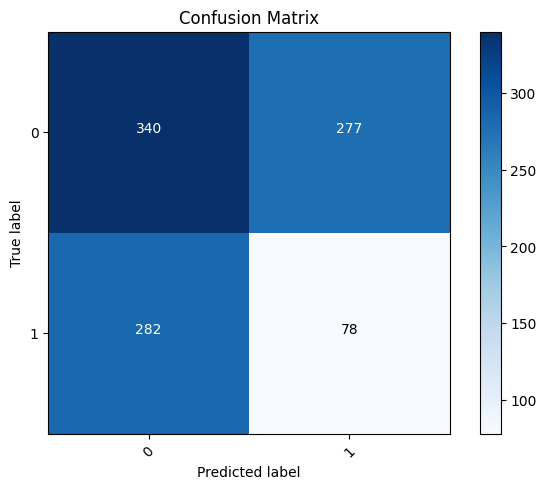

In [119]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))

**Random Undersampling**

In [135]:
from imblearn.under_sampling import RandomUnderSampler
#Now lets try random undersampling 
rus = RandomUnderSampler(random_state=0)
t_annotations_data, t_annotations_target = rus.fit_resample(t_annotations.drop(["HP"], axis=1), t_annotations['HP'])
print(len(t_annotations_data["SSA"] == True), len(t_annotations_data["SSA"] == False))
t_annotations_data["HP"] = t_annotations_target
train_annotations_rus, val_annotations_rus = train_test_split(t_annotations_data, train_size=0.8, stratify=t_annotations_data["HP"])

#Below is the training datasets
train_dataset_rus = Plyops(train_annotations_rus, root_dir, transform)
val_dataset_rus = Plyops(val_annotations_rus, root_dir, transform)

batch_size = 32

train_dataloaders_rus = {'train': DataLoader(train_dataset_rus, batch_size=batch_size), 
                                                    'val': DataLoader(val_dataset_rus, batch_size=batch_size)}
print(len(train_dataset_ros), len(train_dataset_rus))

1260 1260
2472 1008


In [ ]:
lr = 5e-4
model = AlexNet(2)

loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
#Small number of epochs since we dont have the computational resources
epochs = 25

args = training_loop(train_dataloaders_ros, model, epochs, loss_function, optimizer, scheduler)

visualize_training(*args)

In [ ]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))

As we can see by the results, it seems like []sampling works better, so lets apply transfer learning to that dataset

Using cache found in /Users/madhavgopakumar/.cache/torch/hub/pytorch_vision_v0.10.0


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (7): Linear(in_features=1000, out_features=2, bias=True)
  (8): Softmax(dim=1)
)
Epoch: 0
Precision: 0.7654723127035831 F1: 0.762987012987013
Recall: 0.7605177993527508 Specificity: 0.7669902912621359
Loss: 0.47907349169254304
Epoch: 1
Precision: 0.8847926267281107 F1: 0.7300380228136882
Recall: 0.6213592233009708 Specificity: 0.919093851132686
Loss: 0.47982439696788787
Epoch: 2
Precision: 0.9238578680203046 F1: 0.7193675889328064
Recall: 0.5889967637540453 Specificity: 0.9514563106796117
Loss: 0.49118761718273163


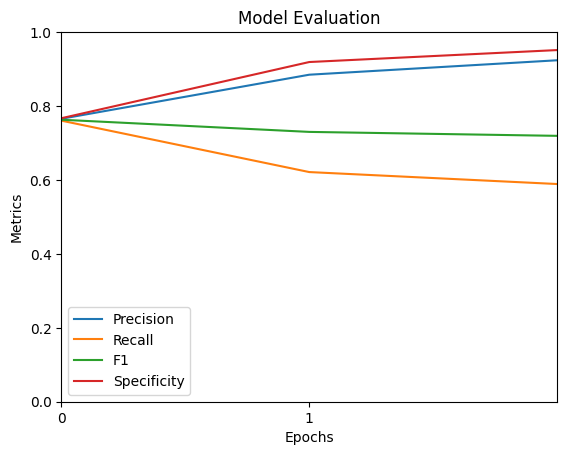

In [145]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='AlexNet_Weights.DEFAULT')
#Changing the fully connected layer to correct output
out_features = model.classifier[-1].out_features
model.classifier.append(nn.Linear(out_features, 2))
model.classifier.append(nn.Softmax(dim=1))

lr = 5e-4
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
#Small number of epochs since we dont have the computational resources
epochs = 25

args = training_loop(train_dataloaders_ros, model, epochs, loss_function, optimizer, scheduler)

visualize_training(*args)

[[322 295]
 [335  25]]
╒═════════╤═════════════╤═══════════╤════════════╤═══════════╕
│ Label   │   Precision │    Recall │   F1-score │   Support │
╞═════════╪═════════════╪═══════════╪════════════╪═══════════╡
│ HP      │    0.490107 │ 0.52188   │  0.505495  │       617 │
├─────────┼─────────────┼───────────┼────────────┼───────────┤
│ SSA     │    0.078125 │ 0.0694444 │  0.0735294 │       360 │
╘═════════╧═════════════╧═══════════╧════════════╧═══════════╛


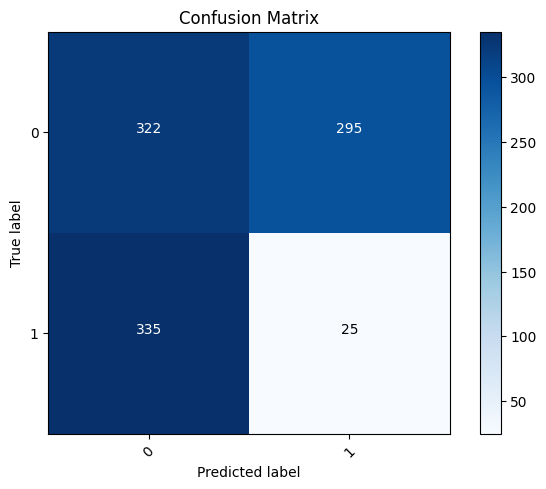

In [146]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))